In [1]:
from epi_model import *

In [2]:
from simulation_manager import *
from simulation_helper import *

In [3]:
argset1

[(frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'}),
  {'INITIAL_INFECT': 20,
   'R0_mean': 2.5,
   'VACCINATE_P': 0.05,
   'strat': <function epi_model.sampling.friend(sim, vaccinateN=100)>}),
 (frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friend'}),
  {'INITIAL_INFECT': 20,
   'R0_mean': 2.5,
   'VACCINATE_P': 0.1,
   'strat': <function epi_model.sampling.friend(sim, vaccinateN=100)>}),
 (frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friend'}),
  {'INITIAL_INFECT': 20,
   'R0_mean': 2.5,
   'VACCINATE_P': 0.2,
   'strat': <function epi_model.sampling.friend(sim, vaccinateN=100)>}),
 (frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friend'}),
  {'INITIAL_INFECT': 20,
   'R0_mean': 2.5,
   'VACCINATE_P': 0.5,
   'strat': <function epi_model.sampling.friend(sim, vaccinateN=100)>}),
 (frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P':

In [2]:
from frozendict import frozendict as fzd

In [162]:
dfs, modelsets = {},{}

In [209]:
names = [
    'HS1_expand300',
    'HS2',
    'synthetic_3'
]

In [210]:
def get_bounds(l, q, z=1.96):
    l = sorted(l)
    n = len(l)

    i = int( np.ceil( n*q - z*np.sqrt(n*q*(1-q)) ) )
    j = int( np.ceil( n*q + z*np.sqrt(n*q*(1-q)) ) )

    return (l[i], l[j])

def none_info(k):
    d = dict(k)
    d['strat'] = 'none'
    d = fzd(d)
    return info(d)

def info(k):
    row = {}
    
    ninf = [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]
    
    for kk,vv in k.items():
        row[kk] = vv

    row['mean'] = np.mean( ninf )
    row['std'] = np.std( ninf )
    row['stderr'] = np.std( ninf ) / np.sqrt( len(ninf) )
    row['Nsims'] = len(ninf)

    for Q in [25, 50, 75]:
        row[f'{Q}p'] = np.quantile( ninf, Q/100 )
        row[f'{Q}pL95'], row[f'{Q}pH95'] = get_bounds( ninf, Q/100 )

    row[f'min'] = np.min(ninf)
    row[f'max'] = np.max(ninf)
    
    row['Nn'] = list(models[k])[0]['numNodes'] # assuming constant

    if k['strat'] != 'none':
        row['init_sus'] = row['Nn']*(1 - k['VACCINATE_P']) - k['INITIAL_INFECT']
        row['P_sus_inf'] = row['mean'] / N_sus

        row['P_sus_inf_rel_none'] = row['P_sus_inf'] / none_info(k)['P_sus_inf']
        row['P_sus_inf_rel_none_err'] = (row['stderr'] / N_sus) / none_info(k)['P_sus_inf'] # should I bootstrap?

    else:
        row['init_sus'] = row['Nn']
        row['P_sus_inf'] = row['mean'] / N_sus

    

        
        
    if np.sum( np.array(ninf) > row['init_sus'] ) != 0:
        print(np.array(ninf), row['init_sus'], row['N'], row['VACCINATE_P'])
        print(k)
    assert( np.sum( np.array(ninf) > row['init_sus'] ) == 0 )

    return row

In [211]:
for name in names:
    
    print(f'loading {name}')

    with open(f'simulation_results/{name}.pickle', 'rb') as inf:
        models = pickle.load(inf)

    rows = []
    for k,ms in models.items():
        rows.append(info(k))

    df = pd.DataFrame.from_records(rows)

    #df.head()
    
    dfs[name] = df
    modelsets[name] = models

loading HS1_expand300
loading HS2
loading synthetic_3


In [212]:
comparisons = {
    'VACCINATE_P': [0.05, 0.10, 0.20, 0.50],
    'R0_mean': [1, 2.5, 4],
    'INITIAL_INFECT': [5, 10, 20]
}

In [213]:
defaults = {
    'R0_mean': 2.5,
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': 20
}

In [214]:
list(models)[0]

frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'})

In [215]:
todel = []
for x in models:
    if 'strat' not in x:
        todel.append( x )
        
for x in todel:
    del models[x]

In [216]:
strats = set(x['strat'] for x in models)
strats = strats.difference({'none'})

In [217]:
strats = sorted(strats)

In [218]:
mean_means = dict(df.groupby('strat')['mean'].mean())

In [219]:
strats = sorted(strats,key=lambda x:-mean_means[x])

In [220]:
strats = [
    'rand',
    'friend',
    'friendHighDegRandTop5',
    'friendHighDegRandTop3',
    'friendHighDegNormalErr20',
    'friendHighDegNormalErr10',
    'targeted',
    'friendHighDeg',
    'friendHighDegChain',
]

# HS1_expand300

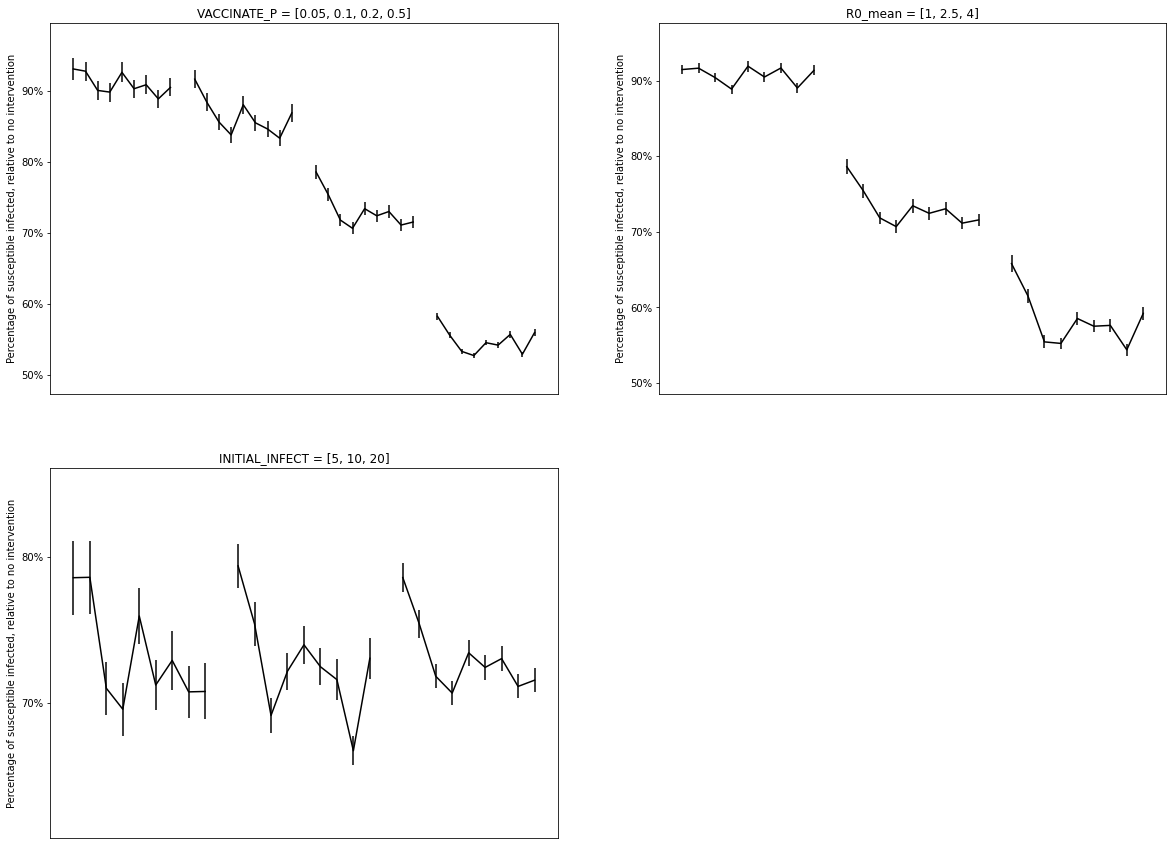

# HS2

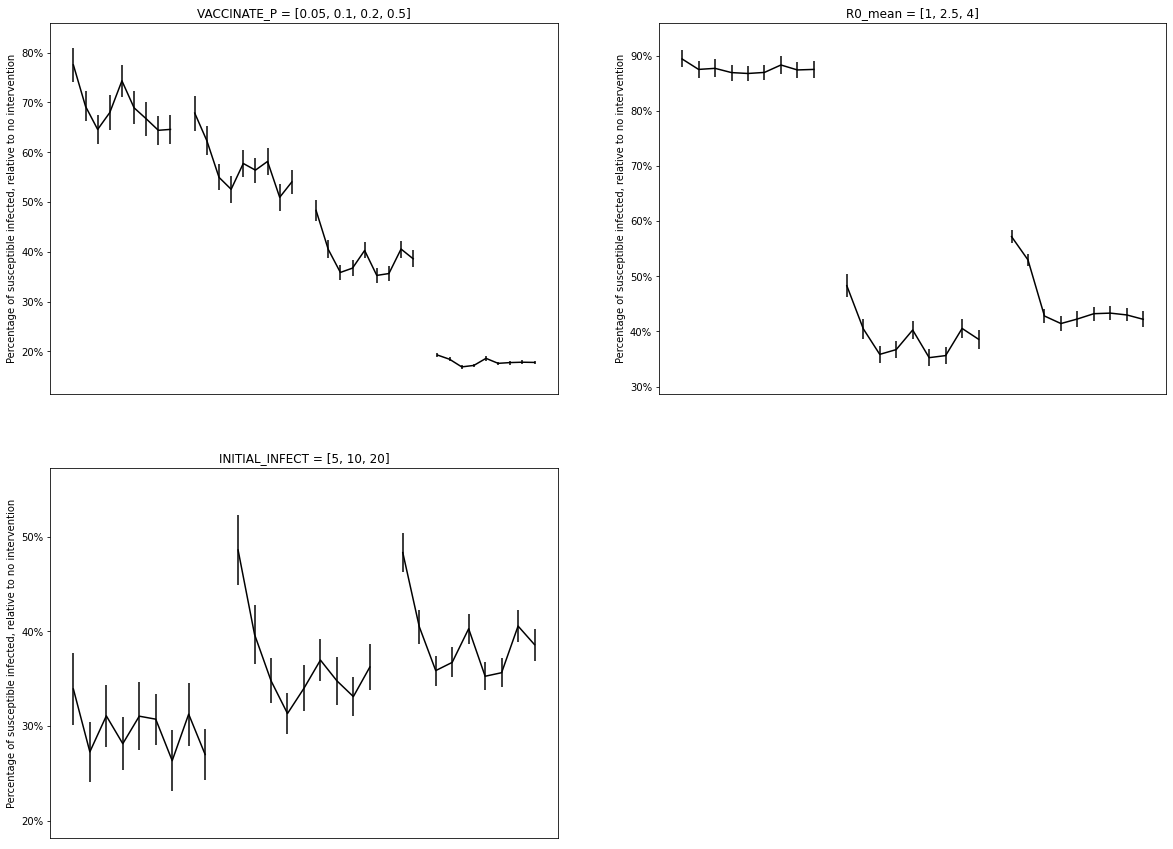

# synthetic_3

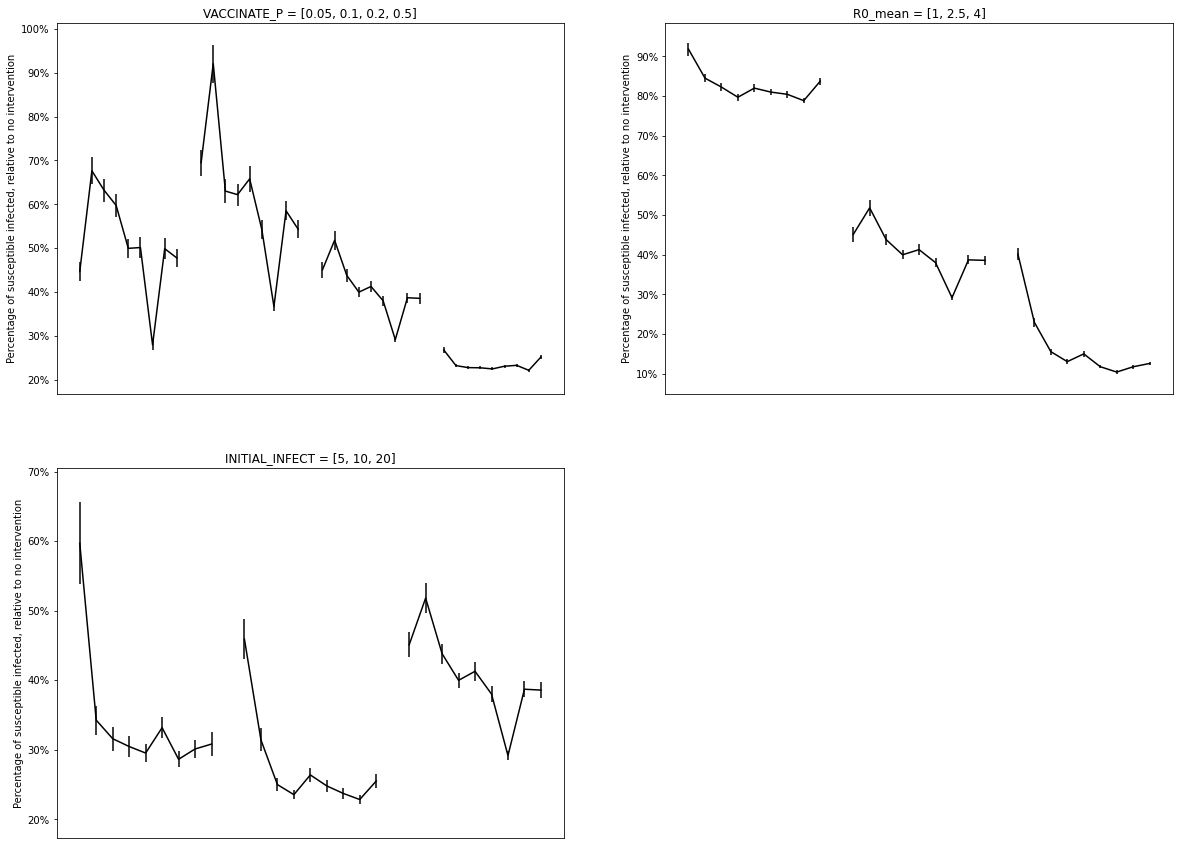

In [226]:
for ni, name in enumerate(names):
    models = modelsets[name]
    df = dfs[name]
    
    display(Markdown(f"# {name}"))

    plt.figure(figsize=(20,15))

    for ci,comp in enumerate(comparisons):
        plt.subplot(2,2,ci+1)
        
        allvs = []
        for Vi,V in enumerate(comparisons[comp]):

            svals = []
            for s in strats:
                d = dict(defaults)
                d[comp] = V
                d['strat'] = s

                inf = info( fzd( d ) )
                #print(inf['mean'], [x['mean'] for x in svals])

                svals.append(inf)


            #[s['N']s['mean'] for s in svals]

            xs = np.linspace(0,0.8,len(svals)) + Vi
            ys = np.array([ s['P_sus_inf_rel_none'] for s in svals ])

            #plt.scatter(xs,ys)
            
            yerrs = np.array([s['P_sus_inf_rel_none_err'] for s in svals ],)

            plt.errorbar(
                xs, ys,
                yerr = yerrs,
                color='black'
            )
            #print([s['min'] for s in svals])
            
            allvs.append( np.min(ys-yerrs)-0.05 )
            allvs.append( np.max(ys+yerrs)+0.05 )

        plt.title(f'{comp} = {comparisons[comp]}')
        
        ytk = np.linspace(0,1.0,11)
        plt.yticks(ytk, [f'{t:0.0%}' for t in ytk])
        plt.ylabel('Percentage of susceptible infected, relative to no intervention')
        plt.ylim( min(allvs),max(allvs) )
        
        plt.xticks([],[])
        
    plt.show()